### Load a map

In [62]:
from pymapmanager.mmMap import mmMap

filePath = 'exampleMaps/rr30a/rr30a.txt'
m = mmMap(filePath=filePath)

map rr30a loaded in 0.45 seconds.


### Generate new analysis by doing algebra on existing annotations

In [63]:
import numpy as np
from pymapmanager.mmUtil import newplotdict

my_pd = newplotdict()
my_pd['segmentid'] = None # None for all map segments
my_pd['xstat'] = 'ubssSum_int2' # background-subtracted spine sum, channel 2
my_pd['ystat'] = 'ubsdSum_int2' # background subtracted dendrite sum, channel 2
my_pd = m.getMapValues3(my_pd)

# make a new matrix to hold the new stat
mRows, nCols = my_pd['x'].shape
myNewStat = np.zeros([mRows,nCols])
myNewStat[:] = 'nan'

# do the algebra
myNewStat = my_pd['x'] / my_pd['y'] # spine intensity / segment intensity

mmMap.getMapValues3() took 0.03 seconds


### Plot our new analysis

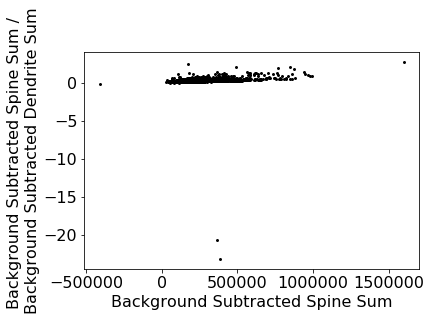

In [64]:
# plot with matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt

# set some matplotlib defaults so our plots look better
import matplotlib as mpl
fontsize = 16
mpl.rcParams['xtick.labelsize'] = fontsize 
mpl.rcParams['ytick.labelsize'] = fontsize 

x = my_pd['x'] # the original 'background subtracted spine sum'
y = myNewStat # our new stat
plt.scatter(x, y, marker='.', c='k', s=15)
plt.xlabel('Background Subtracted Spine Sum', fontsize=16)
plt.ylabel('Background Subtracted Spine Sum / \nBackground Subtracted Dendrite Sum', fontsize=16)
plt.show()

## Homework

 - Do the same but limit analysis to one map segment. Hint, use pd['segmentID']=[1] for segment 1.
 - Do the same but get statistics (mean/sd/se) for each map segment

### Nearest neighbor analysis along a dendritic segment

This will pull a spine annotation and calculate its autocorrelation with its nearest neighbors along a segment.

Autocorrelation of a spine with its neighbor is the autocorrelation at lag 1.

In [65]:
# See: http://greenteapress.com/thinkdsp/html/thinkdsp006.html

def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave[lag:]
    y2 = wave[:n-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

def autocorr(wave):
    lags = range(len(wave)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

def segmentAnalysis(map, ps):
    ps['ystat'] = 'pDist'

    result = np.zeros([map.numMapSegments,map.numSessions])
    result[:] = 'nan'
    
    for i in range(map.numMapSegments):
        for j in range(map.numSessions):
            stackSegment = map._getStackSegmentID(i, j)
            if stackSegment is not None:
                ps['segmentid'] = [stackSegment]
                ps = map.stacks[j].getStackValues3(ps)
                # sort by pDist and make ['x'] values follow
                sortedIdx = np.argsort(ps['y'])
                xSorted = ps['x'][sortedIdx]
                ySorted = ps['y'][sortedIdx]
                
                xSorted = xSorted[~np.isnan(xSorted)]
                [lags, corrs] = autocorr(xSorted)
                result[i,j] = corrs[1]
    return result


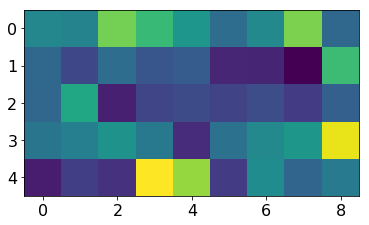

Text(0,0.5,u'Map Segment')

In [66]:
ps = newplotdict()
ps['xstat'] = 'ubssSum_int2' # spine intensity, channel 2

# each value in result[i][j] is the autocorrelation at lag 1 for each map segment (i) at each session (j).
result = segmentAnalysis(m, ps)

plt.imshow(result)
plt.show()
plt.xlabel('Session Number', fontsize=16)
plt.ylabel('Map Segment', fontsize=16)


See:
    
    